In [1]:
using ConstLab
using Plots
using Voigt

[Plots.jl] Default backend: immerse


In [53]:
include("mises_mixed_hardening.jl")

compute_residual (generic function with 1 method)

### Parameters

In [227]:
σy = 200.0*10^6
mp = MisesMixedHardMP(
E = 200.0 * 10^9,
ν =  0.3,
σy =  σy,
H = 0.1 * 200*10^9,
κ∞ = 0.2 * σy,
α∞ = 0.2 * σy,
r = 0.5)

MisesMixedHardMP
  E: 2.0e11
  ν: 0.3
  Ee: 6x6 Array{Float64,2}:
 2.69231e11  1.15385e11  1.15385e11  0.0         0.0         0.0       
 1.15385e11  2.69231e11  1.15385e11  0.0         0.0         0.0       
 1.15385e11  1.15385e11  2.69231e11  0.0         0.0         0.0       
 0.0         0.0         0.0         7.69231e10  0.0         0.0       
 0.0         0.0         0.0         0.0         7.69231e10  0.0       
 0.0         0.0         0.0         0.0         0.0         7.69231e10
  σy: 2.0e8
  H: 2.0e10
  r: 0.5
  κ∞: 4.0e7
  α∞: 4.0e7
  loading: false

### Material Status

In [4]:
ms = MisesMixedHardMS()

MisesMixedHardMS
  ₙεₚ: [0.0,0.0,0.0,0.0,0.0,0.0]
  ₙσdev: [0.0,0.0,0.0,0.0,0.0,0.0]
  ₙαdev: [0.0,0.0,0.0,0.0,0.0,0.0]
  ₙκ: 0.0
  ₙμ: 0.0
  loading: false

### Load case: Plain Strain

In [139]:
tend = 1.0
ts = collect(linspace(0, tend, 100))
ε_max = 0.015
εs_pstrain, σs_pstrain, ε_control_pstrain = loadcase(:uniaxial_strain, ε_max, ts);
@time εs_res_pstrain, σs_res_pstrain, matstats = driver(stress, ATS, ms, mp, ts, εs_pstrain, 
                                                  σs_pstrain, ε_control_pstrain, ftol = 1e-5);

  0.428085 seconds (184.77 k allocations: 11.466 MB)


### Load case: Plain Uniaxial stress

In [140]:
ts = collect(linspace(0, 1, 100))
ε_max = 0.015
εs_ps, σs_ps, εc_ps= loadcase(:uniaxial_stress, ε_max, ts);
Profile.clear()
@profile @time εsres_ps, σsres_ps, mss = driver(stress, ATS, ms, mp, ts, εs_ps, 
                                 σs_ps, εc_ps, ftol = 1e-5);

### Plotting

In [141]:
vm(x) = sqrt(3/2) * vnorm(dev(x))

vm (generic function with 1 method)

1.413521 seconds (1.04 M allocations: 65.942 MB, 3.71% gc time)


[Plots.jl] Switched to backend: gadfly

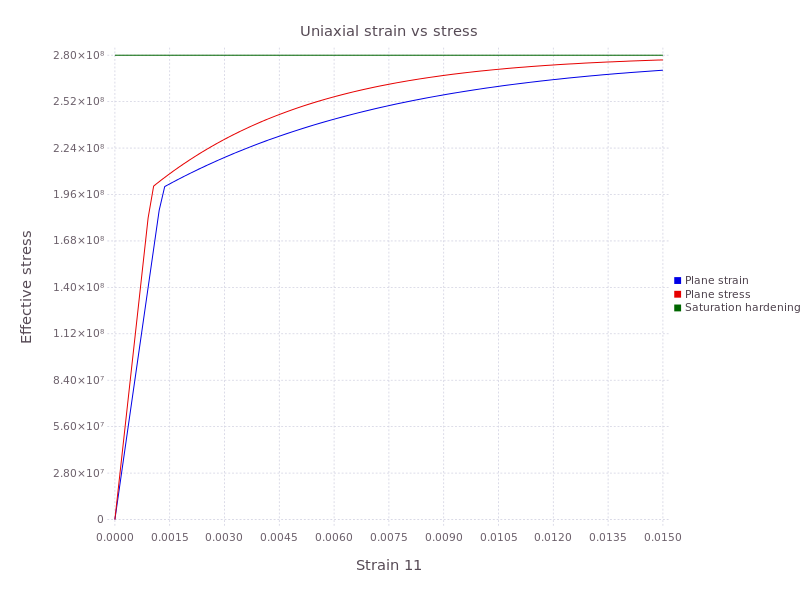

In [143]:
gadfly()
nt = size(σsres_ps,2)
p = plot(vec(εs_res_pstrain[1,:]), Float64[vm(σs_res_pstrain[:,i]) for i in 1:nt], 
label="Plane strain", xticks = linspace(0, 0.015, 11), yticks = linspace(0, mp.κ∞ + mp.α∞ + mp.σy, 11))
plot!(vec(εsres_ps[1,:]), Float64[vm(σsres_ps[:,i]) for i in 1:nt], label="Plane stress")
plot!(vec(εsres_ps[1,:]), (mp.κ∞ + mp.α∞ + mp.σy) * ones(ts), label="Saturation hardening")
xlabel!(p, "Strain 11"); ylabel!(p, "Effective stress"); title!(p, "Uniaxial strain vs stress")

In [72]:
cd("/home/kristoffer/Dropbox/PhD/Courses/Advanced\ material\ mechanics/Mixed_Plast/")

In [144]:
savefig("plane_strain_stress.png")

In [146]:
function cyclic(σ0, σ_ampl, tend, ntspercyc, cycles)
    nts = ntspercyc*cycles
    ω = 2π * cycles / tend
    wt0 = asin(-σ0/σ_ampl)
    function σf(t)
        σ0 + σ_ampl * sin(ω * t+ wt0)
    end
    ts = collect(linspace(0, tend, nts))
    σs = zeros(6, nts)
    σs[1,:] = map(σf, ts)
    εs = zeros(6, nts)
    ε_control = map(Bool, [0, 0, 0, 1, 1, 1]);
    return σs, εs, ε_control, ts
end
σ0 = σy*0.1
σ_ampl = (mp.σy + 0.8*(mp.κ∞ + mp.α∞) - σ0)
tend = 1.0
nts = 100
cycles = 5
σs, εs, ε_control, ts = cyclic(σ0, σ_ampl, tend, nts, cycles)
plot(ts, vec(σs[1,:]); label ="Prescribed stress")
plot!(ts, (mp.κ∞ + mp.α∞ + mp.σy) * ones(ts), label="Saturation hardening")
plot!(ts, σ0 * ones(ts), label="Mean stress")

xlabel!("t")
ylabel!("σ₁₁")
title!("Cyclic stress load")
savefig("cyc_stress_load")

In [119]:
σs, εs, ε_control, ts = cyclic(σ0, σ_ampl, tend, nts, cycles)
εs_res, σs_res, matstats = driver(stress, ATS, ms, mp, ts, εs, σs, ε_control);

[Plots.jl] Switched to backend: gadfly

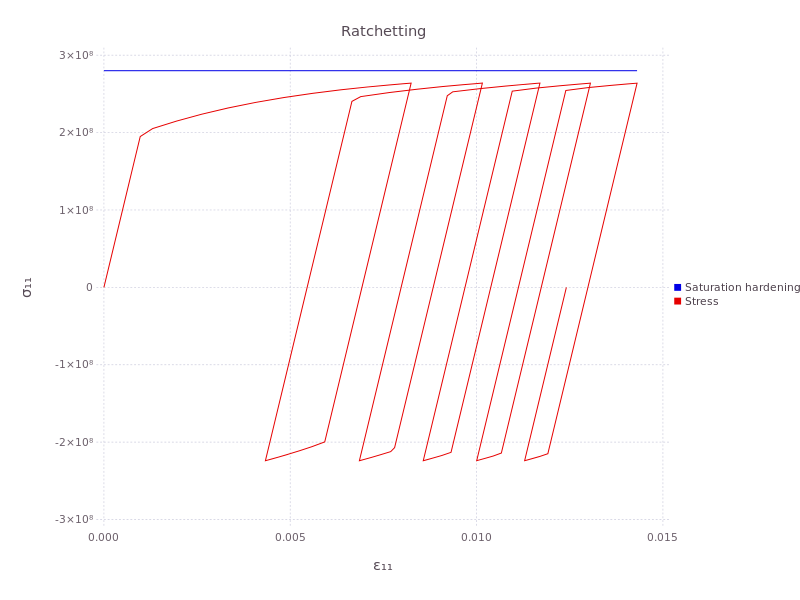

In [120]:

p = plot(vec(εs_res[1,:]), (mp.κ∞ + mp.α∞ + mp.σy) * ones(ts), label="Saturation hardening")
plot!(vec(εs_res[1,:]), vec(σs_res[1,:]), label="Stress")
title!("Ratchetting")
xlabel!("ɛ₁₁")
ylabel!("σ₁₁")

In [121]:
savefig("ratchetting.png")

In [236]:
using Colors
cols = distinguishable_colors(10)
p = Plots.plot()
for (i,k) in enumerate(linspace(0.86, 0.6, 10))
    σ0 = σy*0.1
    σ_ampl = (mp.σy + k*(mp.κ∞ + mp.α∞) - σ0)
    
    tend = 1.0
    nts = 50
    cycles = 10
    σs, εs, ε_control, ts = cyclic(σ0, σ_ampl, tend, nts, cycles)
    εs_res, σs_res, matstats = driver(stress, ATS, ms, mp, ts, εs, σs, ε_control);
    lbl = @sprintf("%3.2e", σ_ampl)
    plot!(0:cycles, Float64[vm(matstats[i].ₙεₚ) for i in 1:49:length(matstats)], 
    label = lbl, color = cols[i], marker = :a, w = 2, xticks = 0:cycles)
end

In [238]:
p
xlabel!("Cycle number")
ylabel!("Effective plastic strain")
title!("Evolution of plastic strain")
savefig("plastic_evo.png")

In [195]:
function cyclic_strain(ɛ_min, ɛ_max, tend, ntspercyc, cycles)
    nts = ntspercyc*cycles
    ω = 2π * cycles / tend
    function ef(t)
        (ɛ_max - ɛ_min) / 2 * sin(ω * t)
    end
    ts = collect(linspace(0, tend, nts))
    σs = zeros(6, nts)
    εs = zeros(6, nts)
    εs[1,:] = map(ef, ts)
    ε_control = map(Bool, [1, 1, 1, 1, 1, 1]);
    return σs, εs, ε_control, ts
end

cyclic_strain (generic function with 1 method)

In [248]:
σy = 200.0*10^6
mp = MisesMixedHardMP(
E = 200.0 * 10^9,
ν =  0.3,
σy =  σy,
H = 0.1 * 200*10^9,
κ∞ = 1.8 * σy,
α∞ = 1.8 * σy,
r = 0.5)


tend = 1.0
nts = 100
cycles = 5
σs, εs, ε_control, ts = cyclic_strain(-0.003, 0.003, tend, nts, cycles)
ε_control = map(Bool, [1, 1, 1, 1, 1, 1])
εs_res, σs_res, matstats = driver(stress, ATS, ms, mp, ts, εs, σs, ε_control);

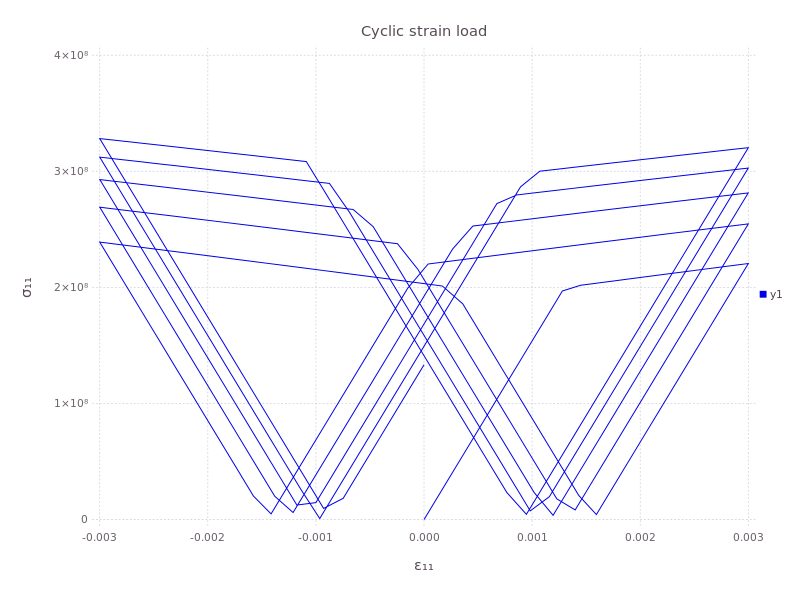

In [250]:
plot(vec(εs_res[1,:]), Float64[vm(σs_res[:,i]) for i in 1:nts*cycles])
title!("Cyclic strain load")
xlabel!("ɛ₁₁")
ylabel!("σ₁₁")
#savefig("cyc_strain_load.png")

In [158]:
ε_control

6-element Array{Bool,1}:
 false
 false
 false
  true
  true
  true